In [1]:
# import Python packages
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import scipy
import scipy.stats as ss
from skbio.stats.distance import permanova
import biom
from biom import load_table
from gemelli.rpca import auto_rpca

### See RPCA standalone python tutorial: 
# https://github.com/biocore/gemelli/blob/master/ipynb/tutorials/RPCA-moving-pictures-standalone-cli-and-api.ipynb

In [2]:
# read in biom table
biom_tbl = biom.load_table("../data/table.filt.zebra10.overlap.biom")

# perform RPCA with auto rank estimation
np.seterr(divide = 'ignore')
ordination, distance = auto_rpca(biom_tbl)

Estimated rank is 3


In [3]:
# extract and view sample ordinations from RPCA result
spca_df = ordination.samples

# convert data to array
spca_df_arr = array(spca_df)
spca_df.head()

,PC1,PC2,PC3
14365.Con.feces.13,0.138484,-0.082237,-0.033783
14365.Con.feces.12,0.014405,0.017604,-0.203437
14365.Con.feces.10,-0.106023,0.049841,0.093119
14365.Con.feces.11,-0.079300,-0.004853,-0.216656
14365.Con.feces.14,0.001388,-0.065644,-0.112263


In [4]:
# view distance matrix
print(distance)

92x92 distance matrix
IDs:
'14365.Con.feces.13', '14365.Con.feces.12', '14365.Con.feces.10', ...
Data:
[[0.         1.94055062 2.68013194 ... 2.80309144 3.02506916 3.10333993]
 [1.94055062 0.         2.06712756 ... 2.06856106 1.67774381 1.82508272]
 [2.68013194 2.06712756 0.         ... 0.17294987 1.02271781 0.96366565]
 ...
 [2.80309144 2.06856106 0.17294987 ... 0.         0.88642802 0.81431926]
 [3.02506916 1.67774381 1.02271781 ... 0.88642802 0.         0.27812703]
 [3.10333993 1.82508272 0.96366565 ... 0.81431926 0.27812703 0.        ]]


In [5]:
# add mouse_type metadata
spca_df["mouse_type"] = ""
spca_df.loc[spca_df.index.str.contains("Con", case=True), 'mouse_type'] = "Control"
spca_df.loc[spca_df.index.str.contains("Wound", case=True), 'mouse_type'] = "Wound"
spca_df.loc[spca_df.index.str.contains("Vanco", case=True), 'mouse_type'] = "Vancomycin"

spca_df

,PC1,PC2,PC3,mouse_type
14365.Con.feces.13,0.138484,-0.082237,-0.033783,Control
14365.Con.feces.12,0.014405,0.017604,-0.203437,Control
14365.Con.feces.10,-0.106023,0.049841,0.093119,Control
14365.Con.feces.11,-0.079300,-0.004853,-0.216656,Control
14365.Con.feces.14,0.001388,-0.065644,-0.112263,Control
...,...,...,...,...
14365.Wound.feces.28,-0.079336,-0.110825,0.068579,Wound
14365.Wound.feces.6,-0.170524,0.074050,0.071520,Wound
14365.Wound.feces.7,-0.117070,0.060846,0.082488,Wound
14365.Wound.feces.8,-0.132247,0.076137,-0.065355,Wound


In [6]:
# extract and view feature ordinations from RPCA result
fpca_df = ordination.features
fpca_df.head()

,PC1,PC2,PC3
G001314975,-0.071171,-0.246387,-0.408019
G000020225,0.211582,-0.338843,-0.310293
G000020205,0.205131,0.430823,-0.433662
G000299455,0.119307,-0.043872,0.368229
G001953785,0.253782,-0.354277,-0.002914


In [7]:
# create color palette
colors = ["#0000FF", "#FFD700", "#FF0000"]
my_colors = sns.set_palette(sns.color_palette(colors))

mouse_types = ["Control", "Vancomycin", "Wound"]
palette = dict(zip(
    mouse_types,
    sns.color_palette(my_colors, len(mouse_types))

))

In [8]:
# calculate permanova F-statistic
pnova_res = permanova(distance, spca_df, "mouse_type")
print(pnova_res)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      92
number of groups                  3
test statistic            17.155107
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


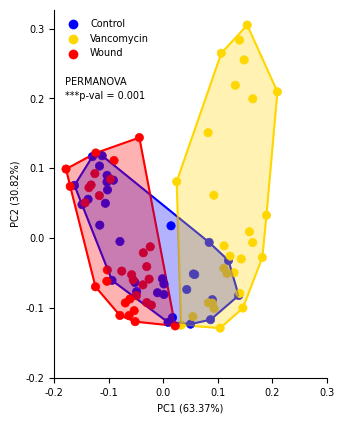

In [9]:
# create beta diversity plot
mm = 1/25.4
fig, ax = plt.subplots(1, 1, figsize=(90*mm, 110*mm))

fpca_df.columns = [f"PC{i+1}" for i in range(fpca_df.shape[1])]

sns.scatterplot(
    data=spca_df,
    x="PC1",
    y="PC2",
    hue="mouse_type",
    edgecolor=None,
    palette=palette,
    ax=ax
)

for mouse_type, mouse_type_df in spca_df.groupby("mouse_type"):
    color = palette[mouse_type]

    points = mouse_type_df[["PC1", "PC2"]].values
    hull = scipy.spatial.ConvexHull(points)

    hull_plot_x = points[hull.vertices, 0]
    hull_plot_y = points[hull.vertices, 1]
    # Connect last point with first point
    hull_plot_x = np.append(hull_plot_x, points[hull.vertices[0], 0])
    hull_plot_y = np.append(hull_plot_y, points[hull.vertices[0], 1])

    ax.plot(
        hull_plot_x,
        hull_plot_y,
        c=color,
        zorder=0
    )
    ax.fill(
        points[hull.vertices, 0],
        points[hull.vertices, 1],
        c=color,
        alpha=0.3
    )


handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=map(str.capitalize, labels),
    frameon=False,
    fontsize = 7
)

pc1_pct, pc2_pct, _ = [f"PC{i+1} ({x*100:.2f}%)" for i, x in enumerate(ordination.proportion_explained)]

ax.set_xlabel(pc1_pct, fontsize = 7)
ax.set_ylabel(pc2_pct, fontsize = 7)

yticklabels = [-0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
yticklocations = yticklabels  # Assuming you want the locations to match the labels
ax.set_yticks(yticklocations)
ax.set_yticklabels(yticklabels, fontsize = 7)

xticklabels = [-0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
xticklocations = xticklabels  # Assuming you want the locations to match the labels
ax.set_xticks(xticklocations)
ax.set_xticklabels(xticklabels, fontsize = 7)

ax.text(-0.18, 0.22, 'PERMANOVA', fontsize=7)
ax.text(-0.18, 0.2, '***p-val = 0.001', fontsize=7)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.tight_layout()
plt.savefig("../plots/Fig_3B_beta_diversity.png", dpi = 600)
plt.show()